<a href="https://colab.research.google.com/github/Xirailuyo/PTLearning/blob/master/Custom_Datasets%2C_Dataloaders%2C_and_Transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion() # Interactive mode

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
landmarks_frame = pd.read_csv('./drive/My Drive/PyTorch/Data/faces/face_landmarks.csv')

n = 65
# landmarks_frame has many columns/attributes
# iloc[n, 0] is the name of the image
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
# [a b c d e f] -> [[a b], [c d], [e, f], ... ]
# getting x and y coordinates for each point
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


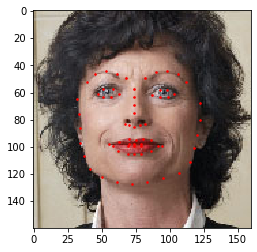

In [0]:
# helper function to show image and landmarks
def show_landmarks(image, landmarks):
  plt.imshow(image)
  plt.scatter(landmarks[:,0], landmarks[:,1], s=10, marker='.', c='r')
  plt.pause(.001) # pause a bit so plot is updated

plt.figure() # create new figure
show_landmarks(io.imread(os.path.join(
    './drive/My Drive/PyTorch/Data/faces/', img_name)),
    landmarks)
plt.show()

# Dataset Class

In [0]:
# torch.utils.data.Dataset: abstract class representing dataset
# inherit and override __len__ and __getitem__
# add transform argument for ease of processing in the future
class FaceLandmarksDataset(Dataset):

  # initialize arguments of class
  def __init__(self, csv_file, root_dir, transform=None):
    """
    Args:
      csv_file (string): Path to the csv file with annotations
      root_dir (string): Directory with all the images
      transform (callable, optional): Optional transform to be applied
        on a sample
    """
    self.landmarks_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  # get length of landmarks array
  def __len__(self):
    return len(self.landmarks_frame)
  
  # get item given index
  def __getitem__(self, idx):
    # turn tensors into lists
    if torch.is_tensor(idx):
      idx = idx.tolist()

    # combine root_dir with name at index
    img_name = os.path.join(self.root_dir,
                            self.landmarks_frame.iloc[idx,0])

    image = io.imread(img_name) # read image
    landmarks = self.landmarks_frame.iloc[idx,1:] # get coordinates
    landmarks = np.array([landmarks]) # turn into array
    # [a b c d e f] -> [[a b], [c d], [e, f], ... ]
    landmarks = landmarks.astype('float').reshape(-1,2)
    # turn into dictionary format
    sample = {'image':image, 'landmarks':landmarks}

    # apply transforms
    if self.transform:
      sample = self.transform(sample)

    return sample

0 (324, 215, 3) (68, 2)


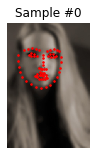

1 (500, 333, 3) (68, 2)


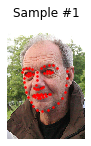

2 (250, 258, 3) (68, 2)


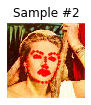

3 (434, 290, 3) (68, 2)


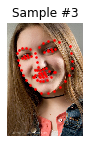

In [0]:
# instantiate class and iterate through data samples
# instantiate class to face_dataset
face_dataset = FaceLandmarksDataset(
    csv_file='./drive/My Drive/PyTorch/Data/faces/face_landmarks.csv',
    root_dir='./drive/My Drive/PyTorch/Data/faces/')

fig = plt.figure()

# go through length of face_dataset or break after 3+1 images
for i in range(len(face_dataset)):
  # take first piece of data from instantiated dataset
  sample = face_dataset[i]

  # data index (height, width, RGB) (#points, xy-columns)
  print(i, sample['image'].shape, sample['landmarks'].shape)

  # print out axis, with landmarks
  ax = plt.subplot(1,4,i+1)
  plt.tight_layout()
  ax.set_title('Sample #{}'.format(i))
  ax.axis('off')
  show_landmarks(**sample)

  if i == 3:
    plt.show()
    break

# Transforms

In [0]:
# neural networks are based on same dimension data
# rescale: scale the image
# randomcrop: to crop from image randomly for data augmentation
# totensor: numpy images to torch images (swap axes)

# for transforms: __call__ method and __init__ method

class Rescale(object):
  """Rescale the image in a sample to a given size.

  Args:
    output_size (tuple or int): Desired output size. If tuple,
    output is matched to output_size. If int, smaller of image
    edges is matched to output_size keeping aspect ratio the same.
  """
  def __init__(self, output_size):
    # throws error if output_size isn't int or tuple
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']

    h, w = image.shape[:2] # height, width
    if isinstance(self.output_size, int):
      # check if height or width is better
      # smaller dimension is resized to output_size
      # larger dimension is resized to > output_size using ratio
      if h > w:
        new_h, new_w = self.output_size * h/w, self.output_size
      else: 
        new_h, new_w = self.output_size, self.output_size * w/h
    else: # if tuple
      new_h, new_w = self.output_size

    new_h, new_w = int(new_h), int(new_w) # ensure values are ints

    # this function is responsible for actual resizing code
    img = transform.resize(image, (new_h, new_w))

    # h and w are swapped for landmarks because x,y = 1,0
    landmarks = landmarks*[new_w/w, new_h/h]

    return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
  """Crop randomly from image

  Args:
    output_size (tuple or int): Desired output size. If int, square crop
  """

  # initialize output_size attribute depending on int or tuple
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      assert len(output_size) == 2
      self.output_size = output_size

  # calling randomcrop function on sample object
  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']

    # get old and new height and widths
    h, w = image.shape[:2]
    new_h, new_w = self.output_size

    top = np.random.randint(0, h-new_h)
    left = np.random.randint(0, w-new_w)

    # indexing image based on top and left values
    image = image[top:top+new_h,
                  left:left+new_w]

    # adjust landmarks accordingly?
    landmarks = landmarks - [left, top]

    return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
  "Convert ndarrays in sample to Tensors"

  def __call__(self, sample):
    image, landmarks = sample['image'], sample['landmarks']

    # swap color axis because
    # numpy image: HxWxC
    # torch image: CxHxW
    image = image.transpose((2,0,1))
    return {'image':torch.from_numpy(image),
            'landmarks':torch.from_numpy(landmarks)}

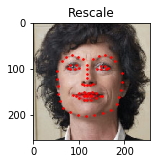

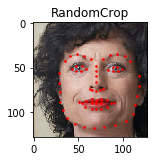

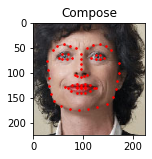

In [0]:
scale = Rescale(256) # initialize square rescale
crop = RandomCrop(128) # initialize random square crop
# torchvision.transforms.Compose allows consolidation of transforms
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = face_dataset[65]
# go through transform for scale, crop, and scale+crop (composed)
for i, tsfrm in enumerate([scale, crop, composed]):
  # transform the sample
  transformed_sample = tsfrm(sample)

  # normal plotting code
  ax = plt.subplot(1,3,i+1)
  plt.tight_layout()
  ax.set_title(type(tsfrm).__name__)
  show_landmarks(**transformed_sample)

plt.show()

# Iterating Through The Dataset

In [0]:
"""
For each sample in dataset:
  1. An image is read from the file on the fly
  2. Transforms are applied on the read image
  3. Since one of the transforms is random, data is augmented on sampling
"""

transformed_dataset = FaceLandmarksDataset(
    csv_file='./drive/My Drive/PyTorch/Data/faces/face_landmarks.csv',
    root_dir='./drive/My Drive/PyTorch/Data/faces/',
    transform=transforms.Compose([
                                   Rescale(256),
                                   RandomCrop(224),
                                   ToTensor()
    ])
)

for i in range(len(transformed_dataset)):
  sample = transformed_dataset[i]

  print(i, sample['image'].size(), sample['landmarks'].size())

  if i==3:
    break

# by only looping through the data, you cannot:
# batch the data, shuffle the data, load the data in parallel

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


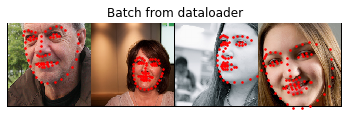

In [0]:
# utils.data.DataLoader provides features that normal looping can't
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# helper function to show a batch
def show_landmarks_batch(sample_batched):
  """Show image with landmarks for a batch of samples."""
  images_batch, landmarks_batch = (sample_batched['image'],
                                   sample_batched['landmarks'])
  batch_size = len(images_batch)
  im_size = images_batch.size(2)
  grid_border_size = 2

  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1,2,0)))

  for i in range(batch_size):
    plt.scatter(landmarks_batch[i,:,0].numpy() + i*im_size + 
                (i+1)*grid_border_size,
                landmarks_batch[i,:,1].numpy() + grid_border_size,
                s=10, marker='.', c='r')
    plt.title("Batch from dataloader")

for i_batch, sample_batched in enumerate(dataloader):
  print(i_batch, sample_batched['image'].size(),
        sample_batched['landmarks'].size())
  
  # observe 4th batch and stop
  if i_batch == 3:
    plt.figure()
    show_landmarks_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    break